In [1]:
import h5py
import re
import hickle as hkl
import torch
import torch.nn as nn
from torch.legacy.nn import Reshape
import graphviz
import torch.nn.functional as F
from torch.autograd import Variable
#from visualize import make_dot
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread, imshow
import time
import logging
from math import log,sqrt

/home/cvrlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
torch.cuda.current_device()

In [2]:
dense201 = models.densenet201(pretrained=True)
#dense161

In [ ]:
#dense201= nn.Sequential(*list(dense201.children())[:-1])
dense201


In [ ]:
# input=Variable(torch.randn(1,3,180,320))
# output=dense201(input)
# print(output.size())

In [3]:
def InitializeWeights(mod):
    for m in mod.modules():
        if isinstance(m,nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            #print m.weight.size(), m.out_channels, m.in_channels
            m.weight.data.normal_(0,sqrt(2./n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.bias.data.zero_()    
    return mod

In [4]:
conv1 = nn.Sequential(nn.BatchNorm2d(1920),nn.ReLU(),nn.Conv2d(1920,1024,1))
conv1 = InitializeWeights(conv1)
conv2 = nn.Sequential(nn.BatchNorm2d(1024),nn.ReLU(),nn.Conv2d(1024,128,5))
conv2 = InitializeWeights(conv2)
conv3 = nn.Sequential(nn.BatchNorm2d(128),nn.ReLU(),nn.Conv2d(128,16,1))
conv3 = InitializeWeights(conv3)
norm1 = nn.BatchNorm2d(16)
norm1 = InitializeWeights(norm1)
fc1 = nn.Linear(96, 1)
fc1 = InitializeWeights(fc1)

In [5]:
class MyModel4(nn.Module):
    def __init__(self, pretrained_model):
        super(MyModel4, self).__init__()
        self.pretrained_model = nn.Sequential(*list(dense201.children())[:-1])
        self.conv1 = conv1
        self.conv2 = conv2
        self.conv3 = conv3
        self.norm1 = norm1
        self.fc1 = fc1
   
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.norm1(x)
        #print(x.size())
        x = x.view(-1, self.num_flat_features(x))
        #print(x.size())
        #x = self.conv4(x)
        x = self.fc1(x)
        return x
#print(net)

In [6]:
net = MyModel4(dense201)

In [ ]:
print(net)


In [20]:
input=Variable(torch.randn(1,3,180,320))
tic=time.time()
output=net(input)
toc=time.time()
print(toc-tic)
print(output.size())

0.4975261688232422
torch.Size([1, 1])


In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

618
torch.Size([64, 3, 7, 7])


In [21]:
sum1 = 0
        
print("Number of layers ---> ",len(list(net.parameters())))
for params in net.parameters():
    if params.requires_grad == True:
        sum1 += params.numel()
    
print("Total number of parameters ---> ",sum1)

Number of layers --->  618
Total number of parameters --->  23345297


In [ ]:
input = Variable(torch.randn(5, 3, 180, 320))
out = net(input)
print(out)

In [10]:
file = h5py.File('./DATASET/CODE/NewTrainData_21000_distance.h5')
xtrainT = torch.from_numpy(np.array(file['xtrain'],dtype=np.float32)).float()
ytrainT = torch.from_numpy(np.array(file['ytrain'],dtype=np.float32)).float()
#xtrain = np.array(file['xtrain'],dtype=np.float32)
#ytrain = np.array(file['ytrain'],dtype=np.float32)

In [22]:
file = h5py.File('./DATASET/CODE/NewTestData_random_distance_1.h5')
xtestT = torch.from_numpy(np.array(file['xtest'],dtype=np.float32)).float()
ytestT = torch.from_numpy(np.array(file['ytest'],dtype=np.float32)).float()
#xtest = np.array(file['xtest'],dtype=np.float32)
#ytest = np.array(file['ytest'],dtype=np.float32)

In [23]:
def batch_rgb_to_bgr(batch):
    #print(batch.size())
    (r, g, b) = torch.chunk(batch, 3, 1)
    #print(r.size())
    batch1 = torch.cat((b, g, r),1)
    #print(batch1.size())
    return batch1

In [24]:
#xtrainT = batch_rgb_to_bgr(xtrainT)
xtestT = batch_rgb_to_bgr(xtestT)
#print(xtrainT.size(), xtestT.size())


In [25]:
#xtrainT = torch.div(xtrainT,255.0)
xtestT = torch.div(xtestT,255.0)

In [ ]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

In [ ]:
print(xtrainT.size(), ytrainT.size(), xtestT.size(), ytestT.size())

In [26]:
class Normalize(object):
    """
    Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [27]:
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
#xtrainT = norm(xtrainT)
xtestT = norm(xtestT)

In [ ]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

In [ ]:
# xtestT = batch_rgb_to_bgr(xtestT)
# xtestT = torch.div(xtestT,255.0)
# mn = [0.406,0.456,0.485]
# sd = [0.225,0.224,0.229]
# norm = Normalize(mn,sd)
# xtestT = norm(xtestT)
# print(xtestT.size(), ytestT.size())
# print(torch.min(xtestT), torch.max(xtestT),torch.min(ytestT), torch.max(ytestT))

In [17]:
##def train(model, loss, optimizer, x_val, y_val, validPixel, batch_sz):
def train(model, loss, optimizer, x_val, y_val,batch_size):
    x = Variable(x_val,requires_grad = False).cuda()
    y = Variable(y_val,requires_grad = False).cuda()
    
    optimizer.zero_grad()
    x = batch_rgb_to_bgr(x)
    x = torch.div(x,255.0)
    mn = [0.406,0.456,0.485]
    sd = [0.225,0.224,0.229]
    x[:,0,:,:] = (x[:,0,:,:]-mn[0])/sd[0]
    x[:,1,:,:] = (x[:,1,:,:]-mn[1])/sd[1]
    x[:,2,:,:] = (x[:,2,:,:]-mn[2])/sd[2]
    
    
    fx = model.forward(x)
    
    #print fx.data[0][0][64][87]
    #fx = model5.forward(Variable(xtest2[start:end], volatile=True).cuda())
    ##output = loss.forward(fx,y,validPixel,batch_sz)
    output = loss.forward(fx,y)
    #output = loss(fx, y)
    output.backward()
    
    optimizer.step()
    
    return output.data[0]

In [18]:
#custom loss function.... this will be reverse Huber...

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self,inp, tar):
        #target is the ground truth value...
        #k = torch.mean(inp[:,0])
        '''
        if (k >= 1.48 and k <= 1.65):
            diff = torch.abs(tar[:,1]-inp[:,1])
            loss = torch.mean(torch.pow(diff,2))
        else:
        '''
        diff = torch.abs(tar[:,0]-inp[:,0]) #*(180/np.pi)
        loss = torch.mean(diff)
        #print(loss)
        return loss
        '''
        c1 = c.data[0] 
        temp = diff > c1
        check1 = torch.prod(temp)
        
        if check1 == 0:
            lossval = torch.mean(diff)
        else:
            temp4 = torch.pow(diff,2)
            d = torch.pow(c,2)
            temp4 = temp4.add(d.expand_as(temp4))
            lossval = torch.mean(temp4/(2*c))
        return lossval
        '''

In [ ]:
import math
class BerhuLoss(nn.Module):
    def __init__(self):
        super(BerhuLoss, self).__init__()
        
    def forward(self,inp, tar):
        #target is the ground truth value...
        mt = tar[:,0]
        mp = inp[:,0]
        diff = torch.abs(mt-mp)        
        lossval = 0.0        
        c = 0.2 * torch.max(diff)
        l1 = torch.mean(diff)
        l2 = torch.mean(torch.pow(diff,2))
        if l1 <= c:
            lossval = l1
        else:
            lossval = (l2+c**2)/(2*c)
        
        return lossval




In [ ]:
#alpha = torch.FloatTensor(ytrainT[5,0])
alpha = ytrainT[5,0]
#print(alpha.shape)
xt = torch.FloatTensor([np.cos(alpha),np.sin(alpha)])
print(ytrainT[5,0],xt.size())

In [ ]:
alpha = ytrainT[5:10,0]
print(torch.cos(alpha[0:1]-alpha[1:2]))
xt = torch.stack([torch.cos(alpha[0:1]),torch.sin(alpha[0:1])])
xp = torch.stack([torch.cos(alpha[1:2]),torch.sin(alpha[1:2])])
print(xt[0],xt[1])
#print(los)

In [ ]:
class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()
        
    def forward(self,inp, tar,batch_sz):
        alpha_t = tar[:,0]
        alpha_p = inp[:,0]
        #xt = torch.stack([torch.cos(alpha_t),torch.sin(alpha_t)])
        #xp = torch.stack([torch.cos(alpha_p),torch.sin(alpha_p)])
        #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #loss = cos(xt, xp)
        #return loss
        loss = Variable(torch.FloatTensor(batch_sz).zero_(), requires_grad=False).cuda()
        for i in range(batch_sz):          
            loss[i] = torch.cos(alpha_t[i:i+1]-alpha_p[i:i+1])
            
        lossval = 1.0-torch.mean(loss)    
        #print(lossval)
        return lossval
        

In [40]:
#MUST UNCOMMENT BELOW LINE...
    
net = net.cuda()

#loading the model after the weights of epoch50.. to check what loss the model gives if lr is taken as 0.0001
optimizer = optim.SGD(net.parameters(), lr=1.6000000000000003e-05, momentum=0.9)

#criterion = RMSELoss()
#criterion = BerhuLoss()
#criterion = EuclideanLoss()
#criterion = nn.MSELoss()
#criterion = CosineLoss()
#criterion = torch.nn.MSELoss(size_average=False)
criterion = CustomLoss()
#criterion = BerhuLoss()
#criterion = CosineLoss()
criterion.cuda()

currepochloss =0.0016930086086116107#float('Inf')
#epochs, n_examples, i, batch_size, flag = 1,5900, 0, 5, 0
epochs, n_examples, i, batch_size, flag = 10, 21000, 0, 35, 0


while i != epochs:
    since = time.time()
    cost, batchloss = 0.0, 0.0
    num_batches = n_examples//batch_size
    #print num_batches    #indices = np.random.permutation(5600)
    #indices = np.random.permutation(3524)
    
    #indices = np.random.permutation(5900)
    indices = np.random.permutation(n_examples)
    samplesUnprocessed = np.size(indices)
    
    #batchwise training starts here...
    for k in range(num_batches):
        since1 = time.time()
       # print("bacth number:"+str(k))
        xtrain3 = torch.FloatTensor(batch_size,3,180,320)
        ytrain3 = torch.FloatTensor(batch_size,1)
        ##validPixel = torch.FloatTensor(batch_size,480,640)
        
        for ind in range(batch_size):
            #ind1 = np.random.randint(0,5599)
            ind1 = np.random.randint(0,samplesUnprocessed)
            #ind1 = np.random.randint(0,794)
            #ind1 = np.random.randint(0,794)            
            newxind = indices[ind1]            
            xtrain3[ind] = xtrainT[newxind]
            ytrain3[ind] = ytrainT[newxind,1,0]
            ##validPixel[ind] = imgValidTrain2[newxind]
            
            #print ytrain3[ind,0,0,0], ytrain2[newxind,0,0,0]
            indices = np.delete(indices,ind1)
            samplesUnprocessed = samplesUnprocessed - 1
        
        #start, end = k*batch_size, (k+1)*batch_size
        #batchloss = train(model5,criterion, optimizer, xtrain3, ytrain3, validPixel,batch_size)
        batchloss = train(net,criterion, optimizer, xtrain3, ytrain3, batch_size)
        batch_time = time.time() - since1
        #cost += batchloss
        cost = (cost*k+batchloss)/(k+1)
        #print k,cost
        #print("No. of samples UnProcessed "+str(samplesUnprocessed))
        
    time_elapsed = time.time() - since
    epochloss = cost #/num_batches
    
    if epochloss < currepochloss:
        print('save the weights')
        torch.save(net.state_dict(),"./weights/CustomLoss_new/DENSE_NET_201_CustomLoss_new_21000_DISTANCE_30+60+28+10_epochs.pth")
        flag = 0
        currepochloss = epochloss
    else:
        flag += 1
        
        if flag == 5:
            for p in optimizer.param_groups:
                lr2 = p['lr']
            newlr = lr2/5
            
            if newlr < 1e-15:
                print("Cant decrease further!!")
                newlr = 1e-15
            flag = 0 
            optimizer = optim.SGD(net.parameters(), lr=newlr, momentum=0.9)
            print("Learning rate changed from "+str(lr2)+" to "+str(newlr))
            
        print("Loss "+str(epochloss)+" is bigger than Loss "+str(currepochloss)+" in the prev epoch ")
        
    print('Loss = {:.8f} at epoch {:d} completed in {:.0f}m {:.0f}s'.format(epochloss,(i+1),(time_elapsed//60),(time_elapsed%60)))
    i += 1 

Loss 0.001713717135523136 is bigger than Loss 0.0016930086086116107 in the prev epoch 
Loss = 0.00171372 at epoch 1 completed in 3m 50s
Loss 0.0017251711738451069 is bigger than Loss 0.0016930086086116107 in the prev epoch 
Loss = 0.00172517 at epoch 2 completed in 3m 52s
Loss 0.0017245792204630562 is bigger than Loss 0.0016930086086116107 in the prev epoch 
Loss = 0.00172458 at epoch 3 completed in 3m 52s
Loss 0.001721098516427446 is bigger than Loss 0.0016930086086116107 in the prev epoch 
Loss = 0.00172110 at epoch 4 completed in 3m 51s
Learning rate changed from 1.6000000000000003e-05 to 3.2000000000000007e-06
Loss 0.0017040715879799483 is bigger than Loss 0.0016930086086116107 in the prev epoch 
Loss = 0.00170407 at epoch 5 completed in 3m 51s
Loss 0.0017015847997390665 is bigger than Loss 0.0016930086086116107 in the prev epoch 
Loss = 0.00170158 at epoch 6 completed in 3m 52s
save the weights
Loss = 0.00166987 at epoch 7 completed in 3m 51s
Loss 0.001682185877289157 is bigger th

In [44]:
for params in optimizer.param_groups:
    print(params['lr'])

3.2000000000000007e-06


In [28]:
net = net.cuda()
net.load_state_dict(torch.load("./weights/CustomLoss_new/DENSE_NET_201_CustomLoss_new_21000_DISTANCE_30+60+28+10_epochs.pth"))

In [30]:
#testing of the architecture...
num_batches = 0
#6 evenly divides the test batch size..
test_batch_size = 20
n_examples = 300
#finalpred = Variable(torch.zeros((n_examples,3,120,160)))
finalpred = Variable(torch.zeros((n_examples,1)))
print("finalpred size is ---> ", finalpred.size())

num_batches = n_examples//test_batch_size
print("num of batches --->", num_batches)
for k in range(num_batches):
    start, end = k*test_batch_size, (k+1)*test_batch_size
    output = net.forward(Variable(xtestT[start:end], volatile=True).cuda())
    finalpred[start:end] = output

finalpred size is --->  torch.Size([300, 1])
num of batches ---> 15


In [ ]:
data1 = finalpred.data.numpy()
print(data1.shape)

In [45]:
#---------------ANGLE------------------------
dif = torch.abs(finalpred.data[:,0]-ytestT[:,0,0])
dif1 = torch.abs((finalpred.data[:,0]-ytestT[:,0,0])/ytestT[:,0,0])
print(dif.size())
#np.savetxt("diff.csv", dif.numpy(), delimiter=",")

MSElossRad = torch.mean(torch.pow(dif,2))
ABSlossRad = torch.mean(dif)
RELlossRad = torch.mean(dif1)
MSElossDeg = MSElossRad*(180/np.pi)
ABSlossDeg = ABSlossRad*(180/np.pi)
RELlossDeg = RELlossRad*(180/np.pi)
print("MSElossRad=="+str(MSElossRad),"ABSlossRad=="+str(ABSlossRad),"RELlossRad"+str(RELlossRad))
print("MSElossDeg=="+str(MSElossDeg),"ABSlossDeg=="+str(ABSlossDeg),"RELlossDeg"+str(RELlossDeg))

torch.Size([300])
MSElossRad==1.2432115745544434 ABSlossRad==1.0831739028294882 RELlossRad0.6902156230807305
MSElossDeg==71.2307762637833 ABSlossDeg==62.061293110843216 RELlossDeg39.54644215651827


In [46]:
#---------------DISTANCE------------------------
dif = torch.abs(finalpred.data[:,0]-ytestT[:,1,0])
dif1 = torch.abs((finalpred.data[:,0]-ytestT[:,1,0])/ytestT[:,1,0])
print(dif.size())
#np.savetxt("diff.csv", dif.numpy(), delimiter=",")

MSElossNor = torch.mean(torch.pow(dif,2))
ABSlossNor = torch.mean(dif)
RELlossNor = torch.mean(dif1)
MSEloss = MSElossNor*320
ABSloss = ABSlossNor*320
RELloss = RELlossNor*320
print("MSElossNor=="+str(MSElossNor),"ABSlossNor=="+str(ABSlossNor),"RELlossNor"+str(RELlossNor))
print("MSEloss=="+str(MSEloss),"ABSloss=="+str(ABSloss),"RELloss"+str(RELloss))

torch.Size([300])
MSElossNor==0.00025876929094103515 ABSlossNor==0.011388288885354996 RELlossNor0.03794423408809962
MSEloss==0.08280617310113125 ABSloss==3.6442524433135985 RELloss12.142154908191877


In [33]:
print(finalpred.size())
print(ytestT.size())

torch.Size([300, 1])
torch.Size([300, 2, 1])


In [61]:
ind = 143
testPT = xtestT[ind]
testPT = testPT.view(1,3,180,320)
tic=time.time()
test_pred = net.forward(Variable(testPT, volatile=True).cuda())
intr=time.time()-tic
print(intr)



0.05514049530029297


Actual angle===90.17575010201176
Pred angle===9.792001665845815


/home/cvrlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/cvrlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


80.38374843616594


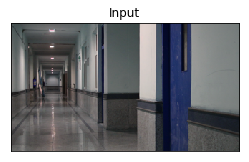

In [32]:
import scipy
from scipy.misc import imresize, imread, imshow
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
import cv2

ind = 143
testPT = xtestT[ind]
print("Actual angle==="+str(ytestT[ind,0,0]*(180/np.pi)))
testPT = testPT.view(1,3,180,320)
test_pred = net.forward(Variable(testPT, volatile=True).cuda())
print("Pred angle==="+str(finalpred.data[ind,0]*(180/np.pi)))
testx = testPT.numpy()
testx = np.reshape(testx,(3,180,320))
testx = testx.transpose(1,2,0)
testx = imresize(testx,(180,320,3))
#imshow(testx)
scipy.misc.imsave('test.png', testx)
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(testx)
a.set_title('Input')
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)



#print(finalpred.data[n,0]*(180/np.pi))
#print(ytestT[ind,0,0]*(180/np.pi))
print(ytestT[ind,0,0]*(180/np.pi)-finalpred.data[ind,0]*(180/np.pi))

In [ ]:
print(ABSlossRad*(180/np.pi))
print(MSEloss*(180/np.pi))

In [ ]:
#print(ytestT[:,0]*(180/np.pi))
#print(ytestT[:,0,2]*(180/np.pi))
a = ytestT[:,0,0]*(180/np.pi)
print(a.size())
np.savetxt("test.csv", a.numpy(), delimiter=",")

In [ ]:
#a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
#np.savetxt("foo.csv", a, delimiter=",")

In [ ]:
#print(finalpred.data[:,0]*(180/np.pi))
print(finalpred.data[:,0]*(180/np.pi))
b = finalpred.data[:,0]*(180/np.pi)
c=torch.abs(ytestT[:,0,0]*(180/np.pi)- finalpred.data[:,0]*(180/np.pi))
np.savetxt("pred.csv", b.numpy(), delimiter=",")

np.savetxt("diff.csv", c.numpy(), delimiter=",")

In [ ]:
finalpred.data[1,0]

In [ ]:
import scipy
from scipy.misc import imresize, imread, imshow
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
import cv2

test = cv2.imread("./Test_Net_image/4.JPG")
print(test.shape)
test = imresize(test,(180,320,3))
#imshow(test)
test = test.transpose(2,0,1)
test = np.reshape(test,(1,3,180,320))
test = test.astype(np.float32)
testPT = torch.from_numpy(test).float()
testPT = batch_rgb_to_bgr(testPT)
testPT = torch.div(testPT,255.0)
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
testPT = norm(testPT)
'''
ind = 2000
testPT = xtestT[ind]
print("Actual angle==="+str(ytestT[ind,0]*(180/np.pi)), ytestT[ind,0])
testPT = testPT.view(1,3,180,320)
#'''
test_pred = net.forward(Variable(testPT, volatile=True).cuda())
print("Angle==="+str(test_pred.data[0,0]*(180/np.pi)), test_pred.data[0,0])
testx = testPT.numpy()
testx = np.reshape(testx,(3,180,320))
testx = testx.transpose(1,2,0)
testx = imresize(testx,(180,320,3))
#imshow(testx)
scipy.misc.imsave('test.png', testx)
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(testx)
a.set_title('Input')
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)